In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

<p align="justify">Pada program ini, digunakan berbagai pustaka (library) penting dalam Python yang menunjang proses pengolahan citra dan analisis klasifikasi secara komprehensif. Library os digunakan untuk mengelola file dan direktori secara efisien, sementara cv2 dari OpenCV dimanfaatkan untuk membaca dan memproses gambar secara langsung. Untuk visualisasi data dan citra, digunakan matplotlib.pyplot dan seaborn yang membantu menampilkan grafik serta heatmap agar hasil analisis lebih mudah dipahami. Library numpy digunakan untuk operasi numerik seperti manipulasi array, dan pandas untuk pengelolaan data dalam bentuk tabel (dataframe).</p> <p align="justify">Untuk proses pembelajaran mesin, library dari sklearn sangat dominan: train_test_split dan cross_val_predict digunakan untuk membagi data latih dan uji serta melakukan validasi silang; accuracy_score, precision_score, recall_score, f1_score, dan classification_report digunakan untuk mengevaluasi performa model secara menyeluruh; sedangkan confusion_matrix dan ConfusionMatrixDisplay menampilkan kesalahan klasifikasi dalam bentuk matriks. Tiga model pembelajaran mesin yang digunakan adalah Random Forest (RandomForestClassifier), Support Vector Machine (SVC), dan K-Nearest Neighbors (KNeighborsClassifier) untuk membandingkan efektivitas tiap algoritma. Di sisi lain, fitur-fitur gambar diekstraksi menggunakan metode dari skimage.feature seperti graycomatrix dan graycoprops untuk menghitung tekstur melalui matriks ko-ocurrence tingkat abu-abu (GLCM), serta entropy dari scipy.stats untuk mengukur tingkat ketidakteraturan dalam citra. Seluruh kombinasi library ini membentuk fondasi yang kuat untuk proyek klasifikasi citra berbasis machine learning yang mendalam dan terstruktur.</p>

# DATA LOADING

In [2]:
data = []
labels = []
file_name = []
target_size = (256, 256)
for sub_folder in os.listdir("Dataset"):
    sub_folder_files = os.listdir(os.path.join("Dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, target_size)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)



<p align="justify">Pada bagian kode ini, dilakukan proses pembacaan dan praproses seluruh citra yang terdapat dalam folder "Dataset", di mana setiap subfolder di dalamnya dianggap sebagai representasi dari satu kelas atau label yang berbeda; untuk setiap gambar yang ditemukan, program membaca citra menggunakan OpenCV (cv.imread), mengubahnya menjadi format tipe data uint8, mengkonversinya dari citra berwarna (BGR) menjadi citra tingkat abu-abu (grayscale) dengan cv.cvtColor, lalu menyesuaikan ukurannya menjadi resolusi tetap yaitu 256x256 piksel menggunakan cv.resize, agar seluruh data gambar memiliki dimensi seragam yang sesuai untuk proses pelatihan model machine learning; setelah diproses, citra grayscale tersebut disimpan dalam list data, label (nama subfolder) disimpan dalam labels, dan nama file gambar (tanpa ekstensi) disimpan dalam file_name untuk keperluan identifikasi atau pelacakan data; pada akhirnya, semua list dikonversi menjadi array NumPy (np.array) agar efisien digunakan dalam analisis dan pelatihan model selanjutnya.</p> 

# Data Understanding

<p align="justify">Pada bagian kode ini, dilakukan visualisasi untuk menampilkan distribusi jumlah data pada setiap kelas dalam dataset, dimulai dengan menggunakan fungsi np.unique untuk menghitung jumlah kemunculan masing-masing label unik yang merepresentasikan kelas-kelas citra, lalu hasilnya divisualisasikan dalam bentuk grafik batang (bar chart) menggunakan matplotlib.pyplot dengan ukuran kanvas 8x5 inci agar proporsional dan mudah dibaca; setiap batang pada grafik menunjukkan banyaknya gambar (data) dalam satu kelas tertentu dengan warna biru muda (skyblue) untuk tampilan yang menarik secara visual, sumbu X diberi label "Kelas" dan sumbu Y menunjukkan "Jumlah Data", sementara judul grafik secara eksplisit menjelaskan bahwa grafik ini menunjukkan "Distribusi Jumlah Data per Kelas"; agar nama-nama kelas tidak saling bertumpukan dan tetap terbaca dengan jelas, label pada sumbu X juga diputar sebesar 45 derajat menggunakan plt.xticks(rotation=45), dan akhirnya grafik ditampilkan ke layar dengan plt.show(), sehingga pengguna dapat dengan cepat memahami keseimbangan atau ketidakseimbangan jumlah data antar kelas yang dapat memengaruhi performa model klasifikasi nantinya.</p>

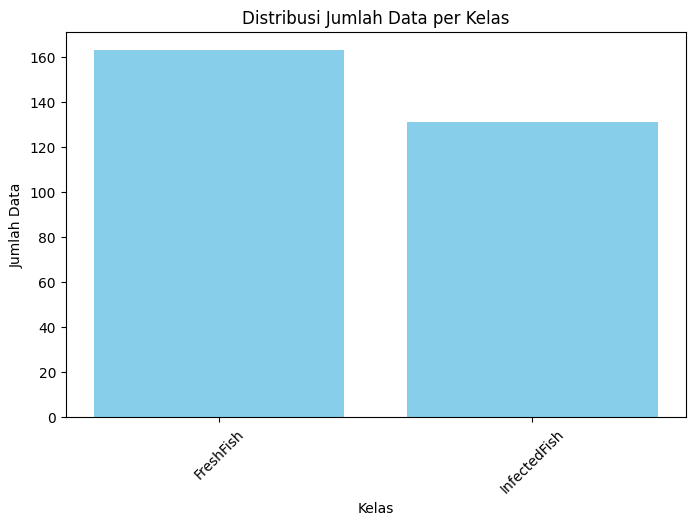

In [3]:
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xticks(rotation=45)
plt.show()

<p align="justify">Pada bagian kode ini, dilakukan analisis visual terhadap distribusi pencahayaan atau intensitas piksel pada gambar ikan sehat ("FreshFish") dan ikan yang terinfeksi ("InfectedFish") dengan cara memisahkan terlebih dahulu data citra berdasarkan labelnya menggunakan list comprehension, di mana masing-masing citra dari kategori "FreshFish" dan "InfectedFish" dikumpulkan dalam list fresh_fish_samples dan infected_fish_samples; kemudian untuk masing-masing kategori tersebut, diambil maksimal lima contoh gambar dan setiap gambar diolah menjadi histogram menggunakan fungsi plt.hist, yang menghitung frekuensi piksel berdasarkan nilai intensitas abu-abu (0 hingga 255) dengan jumlah bin sebanyak 256 sehingga setiap nilai intensitas direpresentasikan secara rinci; histogram ditampilkan dalam grafik berukuran 8x5 inci, dengan tingkat transparansi 0.5 (alpha=0.5) agar kurva dari beberapa sampel bisa ditumpuk dan tetap terlihat jelas, serta masing-masing grafik diberi label sampel agar dapat dibedakan antar kurva; sumbu X menunjukkan intensitas piksel sedangkan sumbu Y menunjukkan frekuensi kemunculan, dan grafik diberi judul masing-masing untuk menunjukkan bahwa yang satu merepresentasikan histogram pencahayaan ikan sehat dan yang lainnya ikan terinfeksi, sehingga dari visualisasi ini, pengguna dapat mengamati perbedaan pola distribusi pencahayaan antar dua kelas yang mungkin dapat dimanfaatkan sebagai fitur dalam proses klasifikasi.</p> 

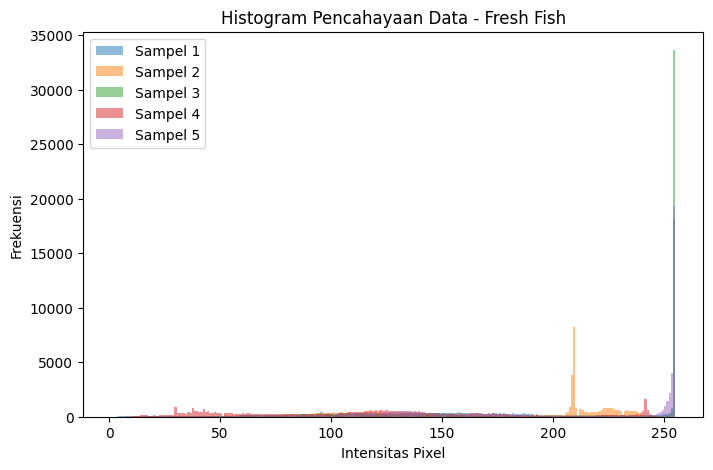

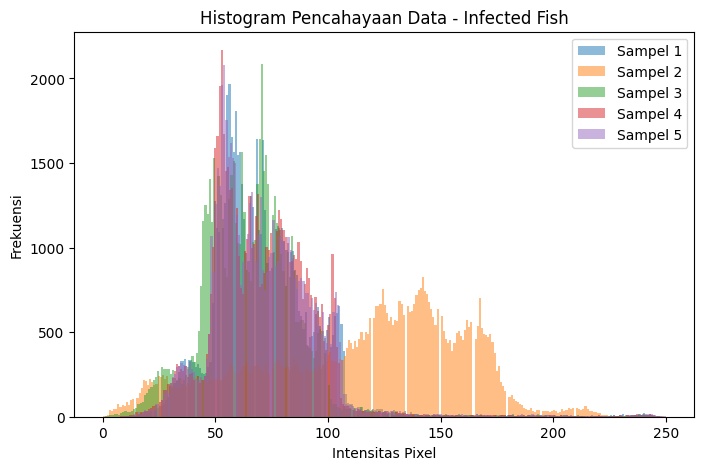

In [4]:
fresh_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "FreshFish"]
infected_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "InfectedFish"]

plt.figure(figsize=(8, 5))
for i in range(min(5, len(fresh_fish_samples))):
    img = fresh_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Fresh Fish")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(min(5, len(infected_fish_samples))):  
    img = infected_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Infected Fish")
plt.legend()
plt.show()

<p align="justify">Pada bagian kode ini, dilakukan visualisasi langsung terhadap contoh citra dari dua kategori yaitu ikan sehat (FreshFish) dan ikan terinfeksi (InfectedFish) dengan tujuan untuk memberikan gambaran visual awal mengenai karakteristik bentuk dan tekstur dari masing-masing kelas, di mana digunakan fungsi plt.subplots untuk membuat sejumlah subplot secara horizontal (1 baris) dengan maksimal lima gambar per kelas agar tampilannya tidak terlalu padat, serta ukuran kanvas ditetapkan sebesar 15x5 inci agar setiap gambar terlihat cukup besar dan jelas; setiap citra ditampilkan dalam skala abu-abu (cmap="gray") menggunakan imshow, dan masing-masing subplot diberi judul spesifik seperti "Ikan Sehat 1" hingga "Ikan Sehat 5" atau "Ikan Terinfeksi 1" hingga "Ikan Terinfeksi 5" agar pengguna dapat mengidentifikasi urutan sampel, sementara axis("off") digunakan untuk menghilangkan sumbu koordinat sehingga fokus tetap tertuju pada konten visual citra itu sendiri, dan seluruh kumpulan subplot diberi judul umum menggunakan plt.suptitle untuk membedakan antara kelompok ikan sehat dan kelompok ikan terinfeksi, yang secara keseluruhan membantu dalam memahami perbedaan visual yang mungkin menjadi indikator penting dalam proses klasifikasi berbasis citra.</p> 

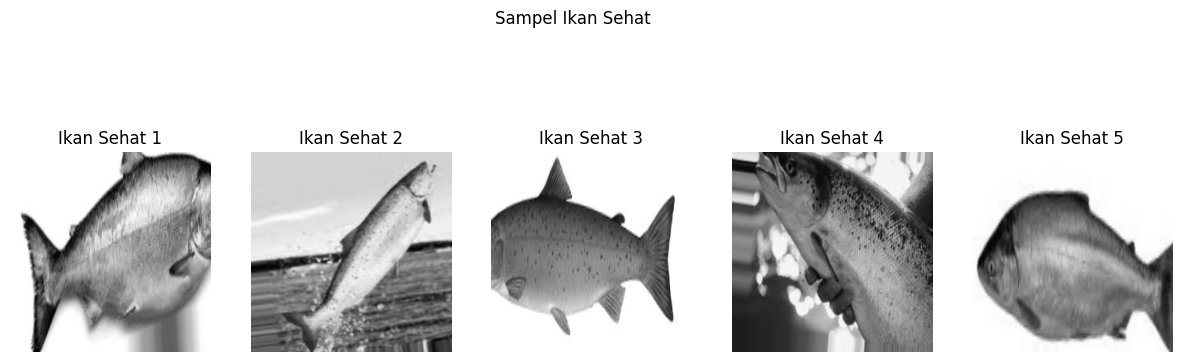

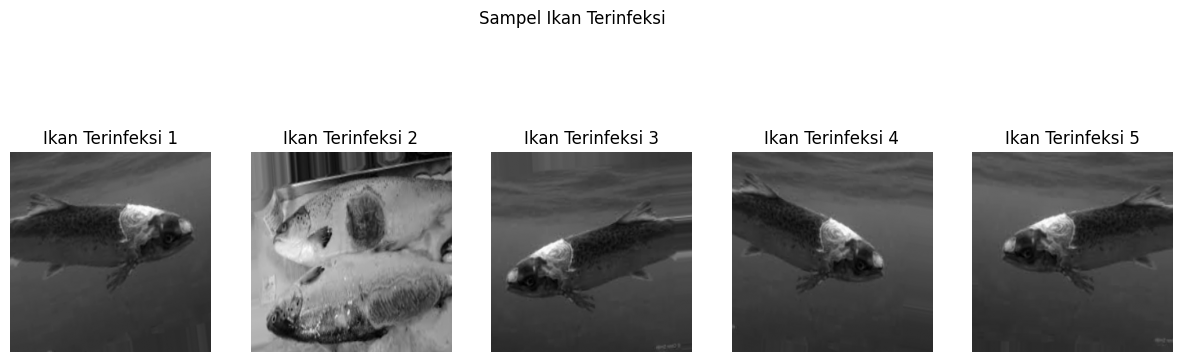

In [5]:
# Menampilkan sampel ikan sehat
fig, axes = plt.subplots(1, min(5, len(fresh_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(fresh_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(fresh_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Sehat {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Sehat")
plt.show()

fig, axes = plt.subplots(1, min(5, len(infected_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(infected_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(infected_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Terinfeksi {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Terinfeksi")
plt.show()

# Data Augmentation

<p align="justify">Pada bagian kode ini, dilakukan proses augmentasi data citra untuk meningkatkan jumlah dan keragaman sampel dalam dataset, yang bertujuan memperkuat performa dan generalisasi model pembelajaran mesin dengan cara menambahkan variasi terhadap citra asli tanpa mengubah label aslinya; proses ini dilakukan dengan membuat salinan dari setiap citra dalam dataset dan kemudian menerapkan empat jenis transformasi sederhana namun efektif, yaitu: flip horizontal (membalik gambar secara mendatar), flip vertikal (membalik gambar secara tegak lurus), rotasi searah jarum jam sebesar 90 derajat (ROTATE_90_CLOCKWISE), dan rotasi 180 derajat (ROTATE_180) yang masing-masing menghasilkan bentuk visual berbeda dari citra asli; hasil transformasi dari setiap citra disimpan dalam sebuah dictionary bernama augmented yang memiliki tiga kunci utama: 'data' untuk menyimpan data gambar hasil augmentasi, 'labels' untuk menyimpan label kelas yang tetap sama dengan citra aslinya, dan 'filenames' untuk menyimpan nama file hasil augmentasi yang diberi akhiran (suffix) seperti _flip_h, _flip_v, _rot_90, dan _rot_180 untuk menandai jenis transformasi yang dilakukan; dengan pendekatan ini, setiap gambar asli menghasilkan empat versi baru yang membuat jumlah data meningkat secara signifikan, yang ditunjukkan dengan mencetak jumlah data sebelum dan sesudah augmentasi untuk memastikan bahwa proses augmentasi berjalan sukses dan memberikan kontribusi besar terhadap pengayaan dataset.</p> 

In [6]:
augmented = {
    'data': [],
    'labels': [],
    'filenames': []
}

# Proses augmentasi
for i in range(len(data)):
    img = data[i]
    label = labels[i]
    filename = file_name[i]

    # 1. Flip Horizontal
    img_flip_h = cv.flip(img, 1)

    # 2. Flip Vertikal
    img_flip_v = cv.flip(img, 0)

    # 3. Rotasi 90 Derajat
    img_rot_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

    # 4. Rotasi 180 Derajat
    img_rot_180 = cv.rotate(img, cv.ROTATE_180)

    # Simpan semua hasil ke dalam dictionary 'augmented'
    augmented_images = [
        (img_flip_h, 'flip_h'),
        (img_flip_v, 'flip_v'),
        (img_rot_90, 'rot_90'),
        (img_rot_180, 'rot_180'),
    ]

    for img_aug, suffix in augmented_images:
        augmented['data'].append(img_aug)
        augmented['labels'].append(label)
        augmented['filenames'].append(f"{filename}_{suffix}")

# Tampilkan hasil
print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(augmented['data']))

Jumlah data sebelum augmentasi: 294
Jumlah data setelah augmentasi: 1176


<p align="justify">Pada bagian kode ini, dilakukan visualisasi terhadap hasil augmentasi data untuk setiap label unik dalam dataset yang telah diperluas, dengan tujuan memberikan gambaran yang jelas mengenai transformasi visual yang diterapkan terhadap citra asli dari masing-masing kelas; pertama-tama, np.unique digunakan untuk mengambil daftar label unik dari data hasil augmentasi, kemudian dilakukan iterasi pada setiap label tersebut, di mana untuk setiap label, sistem mengambil semua gambar yang memiliki label yang sama dan memilih satu contoh citra (sample) dari kumpulan tersebut sebagai representasi visual; selanjutnya, disiapkan tampilan menggunakan plt.subplots dengan lima kolom secara horizontal (1 baris, 5 gambar) berukuran 20x5 inci untuk menampilkan citra asli dan keempat variasi hasil augmentasinya secara berdampingan; setiap gambar diberi judul yang informatif sesuai dengan jenis augmentasi seperti "Original", "Flip H" (horizontal), "Flip V" (vertikal), "Rotasi 90°", dan "Rotasi 180°", serta label kelas yang sesuai, sedangkan fungsi imshow digunakan untuk menampilkan gambar dalam mode abu-abu (cmap="gray"), axis("off") dipanggil untuk menghilangkan sumbu koordinat agar tampilan lebih bersih, dan plt.suptitle digunakan untuk memberi judul keseluruhan yang menunjukkan bahwa baris tersebut menampilkan sampel dan hasil augmentasi dari suatu label tertentu; dengan demikian, visualisasi ini memberikan wawasan penting mengenai bagaimana augmentasi menghasilkan variasi visual dari citra asli yang tetap merepresentasikan informasi kelas yang sama, serta memastikan bahwa proses augmentasi berjalan sesuai harapan dalam memperkaya dataset tanpa merusak konteks visual yang relevan bagi model pembelajaran mesin.</p> 

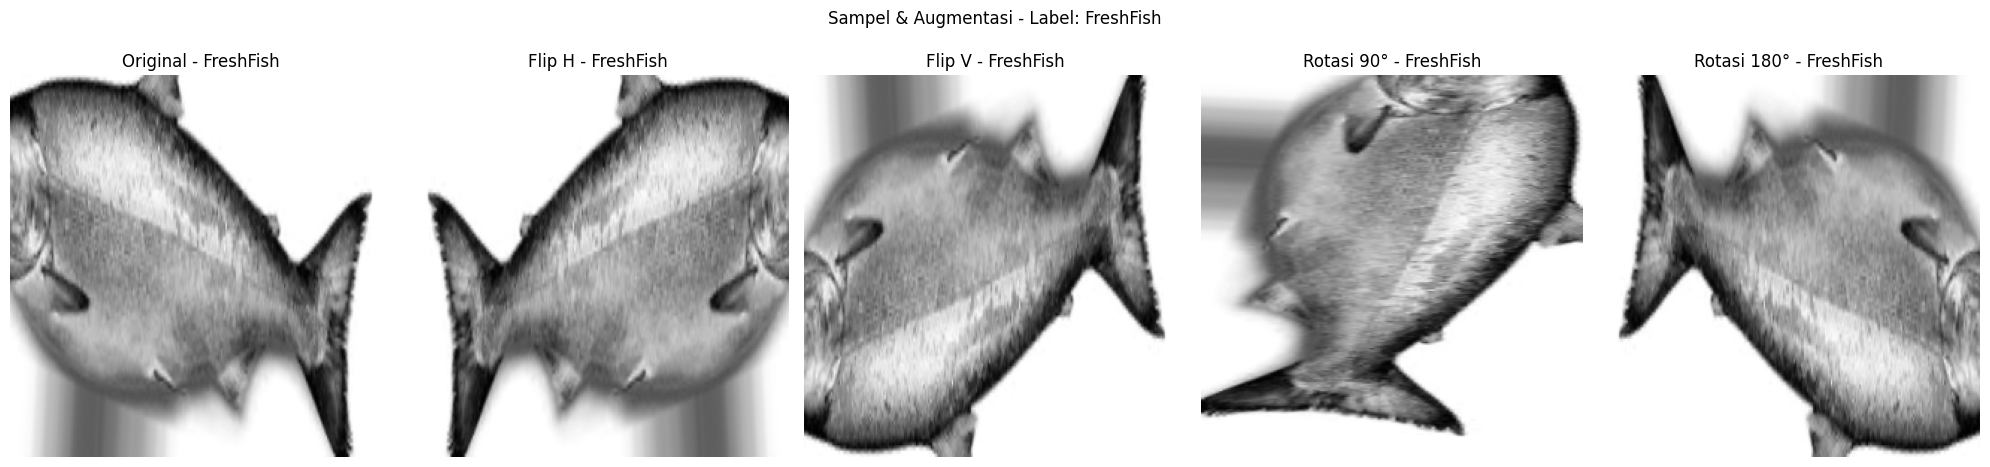

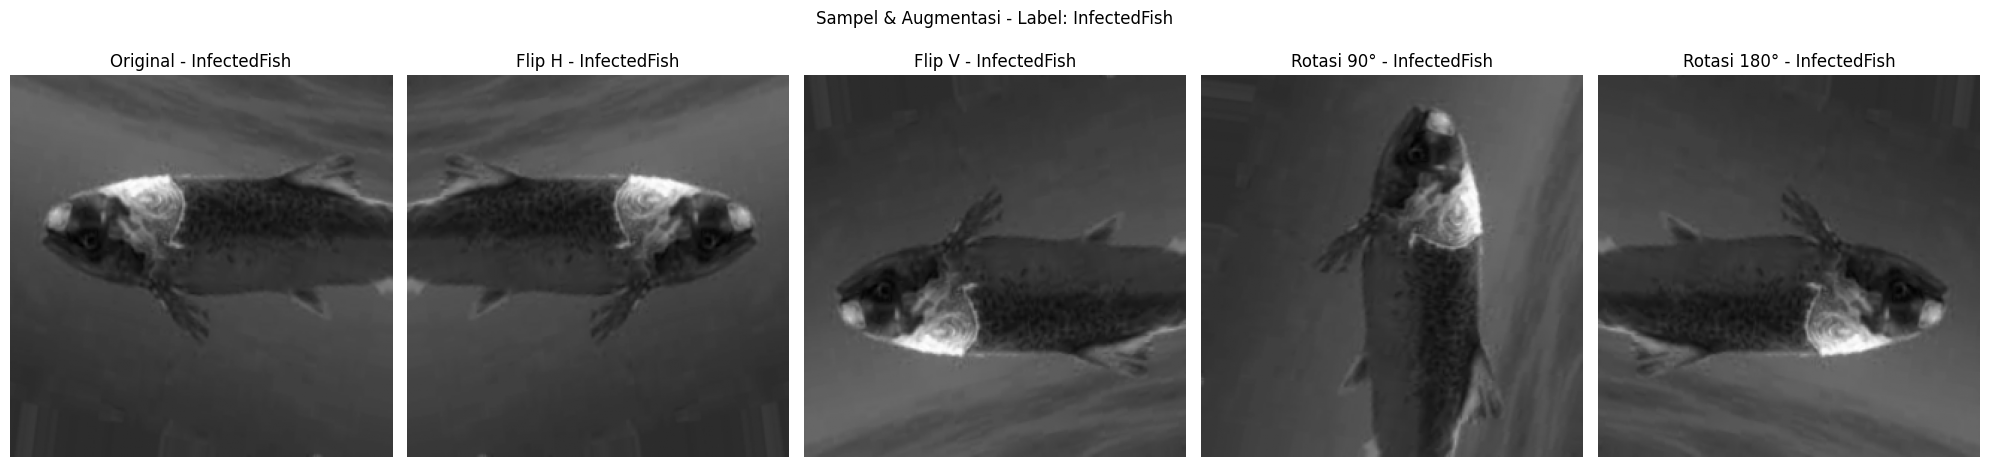

In [7]:
# Ambil label unik dari data yang telah di-augmentasi
unique_labels = np.unique(augmented['labels'])

for label in unique_labels:
    # Ambil semua gambar yang label-nya sama
    samples = [augmented['data'][i] for i in range(len(augmented['labels'])) if augmented['labels'][i] == label]

    if len(samples) > 0:
        sample_img = samples[0]  # Ambil satu contoh gambar

        # Siapkan tampilan
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        augment_titles = ["Original", "Flip H", "Flip V", "Rotasi 90°", "Rotasi 180°"]

        # Daftar gambar hasil augmentasi tanpa translasi
        augmentations = [
            sample_img,
            cv.flip(sample_img, 1),
            cv.flip(sample_img, 0),
            cv.rotate(sample_img, cv.ROTATE_90_CLOCKWISE),
            cv.rotate(sample_img, cv.ROTATE_180)
        ]

        # Tampilkan semua hasil dalam satu baris
        for i in range(5):
            axes[i].imshow(augmentations[i], cmap="gray")
            axes[i].set_title(f"{augment_titles[i]} - {label}")
            axes[i].axis("off")

        plt.suptitle(f"Sampel & Augmentasi - Label: {label}")
        plt.tight_layout()
        plt.show()


# Preprocessing

In [ ]:
def normalize(img):
    img = img.astype(np.float32)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val == 0:
        return np.zeros_like(img, dtype=np.uint8)
    norm_img = (img - min_val) / (max_val - min_val) * 255
    return norm_img.astype(np.uint8)

def histogram_equalization(img):
    # Histogram Equalization secara manual
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_min = cdf_masked.min()
    cdf_max = cdf_masked.max()
    cdf_masked = (cdf_masked - cdf_min) * 255 / (cdf_max - cdf_min)
    cdf_final = np.ma.filled(cdf_masked, 0).astype('uint8')
    img_eq = cdf_final[img]
    return img_eq

def mean_filter(img, ksize=3):
    # Padding image
    pad = ksize // 2
    padded_img = np.pad(img, pad, mode='reflect')
    output = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded_img[i:i+ksize, j:j+ksize]
            output[i, j] = np.mean(region)
    return output.astype(np.uint8)

def median_filter(img, ksize=3):
        # Padding image
        pad = ksize // 2
        padded_img = np.pad(img, pad, mode='reflect')
        output = np.zeros_like(img, dtype=np.float32)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded_img[i:i+ksize, j:j+ksize]
                output[i, j] = np.median(region)
        return output.astype(np.uint8)

def morphological_opening(img, ksize=3):
        # Erosi diikuti dilasi (opening)
        pad = ksize // 2
        kernel = np.ones((ksize, ksize), dtype=np.uint8)
        # Erosi
        eroded = np.zeros_like(img)
        padded_img = np.pad(img, pad, mode='edge')
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded_img[i:i+ksize, j:j+ksize]
                eroded[i, j] = np.min(region[kernel == 1])
        # Dilasi
        padded_eroded = np.pad(eroded, pad, mode='edge')
        opened = np.zeros_like(img)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded_eroded[i:i+ksize, j:j+ksize]
                opened[i, j] = np.max(region[kernel == 1])
        return opened

def morphological_closing(img, ksize=3):
        # Dilasi diikuti erosi (closing)
        pad = ksize // 2
        kernel = np.ones((ksize, ksize), dtype=np.uint8)
        # Dilasi
        dilated = np.zeros_like(img)
        padded_img = np.pad(img, pad, mode='edge')
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded_img[i:i+ksize, j:j+ksize]
                dilated[i, j] = np.max(region[kernel == 1])
        # Erosi
        padded_dilated = np.pad(dilated, pad, mode='edge')
        closed = np.zeros_like(img)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded_dilated[i:i+ksize, j:j+ksize]
                closed[i, j] = np.min(region[kernel == 1])
        return closed

def prewitt_operator(img):
        # Prewitt operator manual
        kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
        kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
        pad = 1
        padded_img = np.pad(img, pad, mode='edge')
        grad_x = np.zeros_like(img, dtype=np.float32)
        grad_y = np.zeros_like(img, dtype=np.float32)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded_img[i:i+3, j:j+3]
                grad_x[i, j] = np.sum(region * kernelx)
                grad_y[i, j] = np.sum(region * kernely)
        grad = np.sqrt(grad_x**2 + grad_y**2)
        grad = np.clip(grad, 0, 255)
        return grad.astype(np.uint8)


<p align="justify">Pada bagian kode ini, didefinisikan serangkaian fungsi yang digunakan untuk pra-pemrosesan citra (image preprocessing) secara manual, yang sangat penting dalam meningkatkan kualitas data sebelum digunakan untuk analisis lebih lanjut seperti ekstraksi fitur atau klasifikasi. Fungsi normalize() digunakan untuk menormalkan intensitas piksel dalam rentang 0–255, menjaga konsistensi skala antar gambar. Fungsi histogram_equalization() berperan untuk meningkatkan kontras gambar dengan mendistribusikan ulang intensitas piksel secara merata, sehingga struktur objek dalam gambar menjadi lebih terlihat. Dua jenis filter juga disediakan, yaitu mean_filter() yang menghaluskan gambar dengan rata-rata lokal dan median_filter() yang efektif dalam mengurangi noise tipe salt-and-pepper tanpa mengaburkan tepi. Selain itu, tersedia fungsi morfologi morphological_opening() dan morphological_closing() yang digunakan untuk membersihkan citra dari noise kecil dan menutup celah-celah kecil di dalam objek, masing-masing dengan operasi erosi-dilasi dan dilasi-erosi. Terakhir, prewitt_operator() digunakan untuk mendeteksi tepi dalam gambar dengan menghitung gradien intensitas secara manual menggunakan operator Prewitt, baik secara horizontal maupun vertikal. Seluruh fungsi ini disusun secara sistematis untuk memungkinkan pemrosesan citra secara mendalam dengan pendekatan berbasis piksel yang fleksibel dan dapat disesuaikan dengan kebutuhan penelitian atau aplikasi tertentu.</p> 

In [9]:
# Percobaan 3: + Opening + Closing + Prewitt
def prepro3(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    mean = mean_filter(eq)
    median = median_filter(mean)
    open_ = morphological_opening(median)
    close = morphological_closing(open_)
    prewitt = prewitt_operator(close)
    return prewitt

<p align="justify">Fungsi prepro3() merupakan bagian dari percobaan ketiga dalam rangkaian pra-pemrosesan citra, yang menyusun beberapa tahapan secara berurutan untuk mempersiapkan gambar sebelum dianalisis lebih lanjut. Proses dimulai dengan normalisasi (normalize) untuk menyamakan skala intensitas piksel antara gambar satu dengan lainnya, sehingga lebih seragam dalam pengolahan. Setelah itu, dilakukan histogram equalization guna meningkatkan kontras gambar agar struktur atau objek di dalamnya menjadi lebih menonjol. Gambar yang sudah ditingkatkan kualitasnya kemudian diperhalus melalui mean filter, yang diikuti oleh median filter untuk menghilangkan noise tanpa mengaburkan detail penting seperti tepi.</p> 

<p align="justify">Setelah proses filtering, dilakukan operasi morfologi yaitu opening (morphological_opening) untuk menghilangkan bintik-bintik kecil atau noise terang yang tidak diinginkan, lalu dilanjutkan dengan closing (morphological_closing) untuk menutup celah kecil di dalam objek atau area gelap. Akhirnya, gambar diproses dengan Prewitt operator, yang bertugas mengekstraksi tepi-tepi objek secara manual berdasarkan perubahan intensitas piksel. Hasil akhir dari fungsi prepro3() adalah gambar dengan kualitas yang telah ditingkatkan, noise yang dikurangi, serta tepi-tepi objek yang lebih jelas—sangat ideal untuk proses ekstraksi fitur atau klasifikasi dalam sistem pengolahan citra.</p> 

In [ ]:
# Inisialisasi list untuk menyimpan hasil preprocessing
dataPreprocessed_3 = []

# Ambil data hasil augmentasi
augmented_data = augmented['data']

# Lakukan preprocessing untuk masing-masing percobaan
for img in augmented_data:
    dataPreprocessed_3.append(prepro3(img))
dataPreprocessed = dataPreprocessed_3

dataPreprocessed_healthy = []
dataPreprocessed_infected = []

labels = augmented['labels']

# Lakukan preprocessing untuk masing-masing percobaan
for img, label in zip(dataPreprocessed, labels):
    if label == "FreshFish":
        dataPreprocessed_healthy.append(img)
    elif label == "InfectedFish":
        dataPreprocessed_infected.append(img)

# Menampilkan 10 sampel gambar dari masing-masing kategori
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(dataPreprocessed_healthy[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Healthy {i+1}")

for i in range(10):
    axes[i+10].imshow(dataPreprocessed_infected[i], cmap='gray')
    axes[i+10].axis('off')
    axes[i+10].set_title(f"Infected {i+1}")

plt.tight_layout()
plt.show()

<p align="justify">Pada bagian kode ini, dilakukan proses praproses lanjutan terhadap seluruh data hasil augmentasi menggunakan fungsi prepro2, kemudian hasilnya dikelompokkan berdasarkan label untuk memudahkan analisis dan visualisasi, serta ditampilkan dalam bentuk galeri sampel yang representatif dari masing-masing kategori; langkah pertama dimulai dengan inisialisasi list kosong dataPreprocessed_2 yang akan menampung hasil praproses dari seluruh gambar yang telah di-augmentasi, di mana setiap gambar dalam augmented['data'] diproses satu per satu menggunakan fungsi prepro2 yang terdiri dari serangkaian tahapan pembersihan dan peningkatan kualitas gambar seperti mean filter, median filter, histogram equalization, dan normalisasi, lalu hasilnya disimpan ke dalam list tersebut;</p> <p align="justify">setelah semua gambar diproses, hasil praproses ini dikategorikan kembali ke dalam dua list terpisah, yaitu dataPreprocessed_healthy untuk gambar yang berlabel “FreshFish” dan dataPreprocessed_infected untuk gambar yang berlabel “InfectedFish”, dengan cara mencocokkan setiap label dalam augmented['labels'] dan memisahkan gambar ke dalam kategori yang sesuai; selanjutnya, dilakukan visualisasi hasil dengan menampilkan total 20 gambar yang telah dipraproses—masing-masing 10 gambar dari ikan sehat dan 10 gambar dari ikan terinfeksi—dalam satu figure dengan susunan grid 4 baris dan 5 kolom menggunakan matplotlib, di mana setiap gambar diberi judul sesuai dengan urutan dan jenisnya serta sumbu koordinat disembunyikan agar tampilan lebih bersih; visualisasi ini sangat penting untuk memastikan bahwa proses praproses yang diterapkan memberikan hasil visual yang konsisten dan layak secara kualitas, serta memberikan gambaran kepada pengguna atau peneliti mengenai karakteristik visual masing-masing kategori pasca praproses, sehingga dapat menjadi dasar untuk analisis lebih lanjut atau evaluasi performa model klasifikasi.</p> 

# Feature Extraction

In [11]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

<p align="justify">Fungsi glcm(image, derajat) ini dirancang untuk menghasilkan matriks co-occurrence tingkat abu-abu (GLCM) dari sebuah citra grayscale berdasarkan sudut tertentu yang ditentukan oleh parameter derajat, di mana fungsi pertama-tama memetakan nilai sudut input (0, 45, 90, atau 135 derajat) ke dalam radian yang sesuai untuk digunakan pada perhitungan GLCM, dan apabila sudut yang diberikan tidak termasuk ke dalam nilai-nilai yang valid, fungsi ini akan memberikan pesan kesalahan yang menjelaskan bahwa hanya sudut 0, 45, 90, dan 135 derajat yang diperbolehkan;</p> <p align="justify">setelah sudut berhasil dipilih dan dikonversi, fungsi kemudian memanggil metode graycomatrix dari pustaka skimage.feature, yang menghitung matriks GLCM dengan jarak piksel tetangga sebesar 1 dan parameter symmetric=True serta normed=True untuk menghasilkan matriks yang simetris dan ternormalisasi, sehingga nilai yang diperoleh dapat merepresentasikan hubungan spasial intensitas piksel dalam citra secara lebih akurat dan stabil; hasil keluaran fungsi ini adalah sebuah matriks GLCM yang dapat digunakan sebagai dasar ekstraksi fitur tekstur seperti kontras, homogenitas, energi, dan korelasi, yang sangat berguna dalam aplikasi pengolahan citra dan klasifikasi berbasis tekstur.</p>

In [12]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

<p align="justify">Fungsi correlation(matriks) ini bertujuan untuk menghitung nilai korelasi tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter 'correlation' digunakan untuk mengekstrak properti korelasi yang mengukur sejauh mana piksel dalam citra memiliki hubungan linier satu sama lain berdasarkan intensitasnya; fungsi ini kemudian mengakses elemen pertama dari hasil yang dikembalikan oleh graycoprops (indeks [0, 0]) untuk mendapatkan nilai korelasi tunggal yang merepresentasikan tingkat keterkaitan antar piksel pada arah dan jarak yang telah ditentukan sebelumnya dalam matriks GLCM, sehingga nilai tersebut dapat digunakan sebagai salah satu fitur penting dalam analisis tekstur dan klasifikasi citra.</p>

In [13]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

<p align="justify">Fungsi dissimilarity(matriks) ini digunakan untuk menghitung nilai ketidaksamaan (dissimilarity) tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter 'dissimilarity' secara spesifik mengambil ukuran yang mencerminkan seberapa besar perbedaan intensitas antara pasangan piksel tetangga dalam citra; fungsi ini kemudian mengakses elemen pertama hasil yang dikembalikan ([0, 0]) untuk memperoleh nilai tunggal ketidaksamaan yang menggambarkan tingkat variasi atau kontras lokal pada gambar berdasarkan hubungan spasial antar piksel, yang sangat berguna dalam proses ekstraksi fitur tekstur guna membedakan pola dan struktur dalam analisis citra dan klasifikasi.</p>

In [14]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

<p align="justify">Fungsi homogenity(matriks) ini bertujuan untuk menghitung nilai homogenitas tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan menggunakan fungsi graycoprops dari pustaka skimage.feature, di mana parameter 'homogeneity' mengukur seberapa seragam atau serapi nilai intensitas piksel dalam citra berdasarkan hubungan spasialnya; fungsi ini kemudian mengambil elemen pertama dari hasil yang dikembalikan ([0, 0]) untuk mendapatkan satu nilai homogenitas tunggal yang menunjukkan tingkat keseragaman tekstur—nilai yang tinggi mengindikasikan bahwa piksel-piksel memiliki intensitas yang serupa dan tersebar merata, sehingga fitur ini sangat berguna dalam membedakan area dengan tekstur halus dari area yang kasar dalam analisis citra dan klasifikasi.</p>

In [15]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

<p align="justify">Fungsi contrast(matriks) ini digunakan untuk menghitung nilai kontras tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter 'contrast' secara spesifik mengukur perbedaan intensitas antara piksel-piksel yang berdekatan dalam citra, sehingga mencerminkan tingkat variasi atau perubahan lokal pada tekstur gambar; fungsi ini kemudian mengambil nilai pada indeks [0, 0] dari hasil keluaran graycoprops untuk memperoleh satu angka kontras tunggal yang menunjukkan seberapa tajam atau kasar tekstur dalam citra tersebut, yang sangat berguna dalam ekstraksi fitur untuk keperluan analisis citra dan klasifikasi pola.</p>

In [16]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

<p align="justify">Fungsi ASM(matriks) ini berfungsi untuk menghitung nilai Angular Second Moment (ASM), yang juga dikenal sebagai energi tekstur, dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan menggunakan fungsi graycoprops dari pustaka skimage.feature, di mana parameter 'ASM' mengukur tingkat keteraturan dan konsistensi tekstur dalam citra dengan menghitung jumlah kuadrat elemen-elemen pada matriks GLCM; fungsi ini kemudian mengambil elemen pertama hasil keluaran ([0, 0]) untuk mendapatkan satu nilai tunggal ASM yang mencerminkan seberapa seragam dan teratur pola intensitas piksel pada citra, sehingga nilai ini sangat berguna sebagai fitur tekstur yang menunjukkan kepadatan dan kestabilan pola untuk keperluan analisis dan klasifikasi citra.</p>

In [17]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

<p align="justify">Fungsi energy(matriks) ini digunakan untuk menghitung nilai energi tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter 'energy' mengukur intensitas atau kekuatan pola tekstur dengan menghitung akar kuadrat dari Angular Second Moment (ASM), sehingga memberikan indikasi tentang keteraturan dan konsistensi distribusi piksel dalam citra; fungsi ini kemudian mengambil elemen pertama hasil keluaran ([0, 0]) untuk mendapatkan satu nilai energi tunggal yang menunjukkan sejauh mana tekstur dalam gambar bersifat homogen dan terstruktur, yang sangat berguna dalam ekstraksi fitur untuk analisis dan klasifikasi citra berbasis tekstur.</p>

In [18]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

<p align="justify">Fungsi entropyGlcm(matriks) ini digunakan untuk menghitung nilai entropi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan cara memanfaatkan fungsi entropy dari pustaka scipy.stats, di mana matriks GLCM tersebut terlebih dahulu diubah menjadi sebuah array satu dimensi (dengan metode .ravel()) agar dapat dihitung distribusi probabilitasnya; entropi ini mengukur tingkat ketidakteraturan atau kompleksitas tekstur dalam citra, di mana nilai entropi yang lebih tinggi menunjukkan pola tekstur yang lebih acak dan tidak teratur, sedangkan nilai yang lebih rendah mengindikasikan pola yang lebih terstruktur dan homogen; oleh karena itu, nilai entropi dari GLCM ini sangat berguna sebagai fitur statistik dalam analisis tekstur untuk membedakan karakteristik visual dari citra yang berbeda.</p>

In [19]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

<p align="justify">Dalam proses ekstraksi fitur tekstur, kode ini melakukan perhitungan matriks Gray Level Co-occurrence Matrix (GLCM) untuk setiap citra hasil preprocessing pada empat arah sudut berbeda yaitu 0°, 45°, 90°, dan 135°, di mana untuk setiap citra yang ada dalam daftar dataPreprocessed, fungsi glcm dipanggil secara berurutan dengan parameter sudut yang sesuai untuk menghasilkan empat matriks GLCM yang merepresentasikan hubungan spasial piksel berdasarkan arah tersebut; kemudian, setiap matriks hasil perhitungan disimpan secara terpisah ke dalam daftar yang berbeda-beda sesuai sudutnya, yakni Derajat0, Derajat45, Derajat90, dan Derajat135, sehingga memungkinkan analisis tekstur yang lebih komprehensif dan detail dengan mempertimbangkan variasi orientasi pola tekstur dalam citra, yang nantinya dapat digunakan untuk ekstraksi fitur statistik guna meningkatkan performa klasifikasi citra berbasis tekstur.</p>

In [20]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

<p align="justify">Kode ini menginisialisasi sejumlah list kosong yang akan digunakan untuk menyimpan nilai-nilai fitur tekstur yang diekstrak dari matriks GLCM pada empat sudut berbeda yaitu 0°, 45°, 90°, dan 135°, di mana setiap fitur tekstur seperti kontras, dissimilaritas, homogenitas, entropi, Angular Second Moment (ASM), energi, dan korelasi memiliki empat list terpisah sesuai dengan sudut pengambilan matriks GLCM-nya; inisialisasi ini bertujuan untuk memudahkan pengorganisasian dan pengelompokan hasil ekstraksi fitur sehingga setiap jenis fitur dapat dianalisis secara spesifik berdasarkan arah sudutnya, memungkinkan evaluasi yang lebih detail dan menyeluruh terhadap karakteristik tekstur dalam citra, yang nantinya akan digunakan untuk keperluan analisis lebih lanjut, seperti pelatihan dan pengujian model klasifikasi.</p>

In [21]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

<p align="justify">Dalam kode ini, dilakukan perhitungan nilai korelasi tekstur untuk setiap citra yang telah melalui preprocessing dengan menggunakan matriks GLCM pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°, di mana pada setiap iterasi loop yang berjalan sebanyak jumlah citra dalam dataPreprocessed, fungsi correlation dipanggil untuk mengambil nilai korelasi dari masing-masing matriks GLCM yang disimpan dalam daftar Derajat0, Derajat45, Derajat90, dan Derajat135; hasil nilai korelasi ini kemudian disimpan secara berurutan ke dalam list khusus sesuai sudutnya, yaitu correlation0, correlation45, correlation90, dan correlation135, sehingga data ini dapat digunakan untuk analisis lebih lanjut yang bertujuan memahami hubungan spasial antar piksel dalam berbagai orientasi tekstur citra.</p>

In [22]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

<p align="justify">Kode ini melakukan perhitungan nilai kontras tekstur dari setiap citra yang sudah melalui tahap preprocessing dengan menggunakan matriks GLCM pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°, di mana pada setiap iterasi loop sebanyak jumlah citra dalam dataPreprocessed, fungsi contrast dipanggil secara berurutan untuk mendapatkan nilai kontras dari matriks GLCM yang tersimpan pada list Derajat0, Derajat45, Derajat90, dan Derajat135; nilai kontras yang dihasilkan kemudian dimasukkan ke dalam list khusus sesuai sudutnya, yakni Kontras0, Kontras45, Kontras90, dan Kontras135, sehingga memudahkan analisis tekstur berdasarkan orientasi sudut yang berbeda untuk setiap citra yang dianalisis.</p>

In [23]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

<p align="justify">Pada bagian kode tersebut, dilakukan proses perhitungan nilai dissimilarity (ketidaksamaan) dari data citra yang telah diproses sebelumnya. Untuk setiap elemen dalam kumpulan data yang telah dipreproses (dataPreprocessed), program akan menghitung nilai dissimilarity dari derajat arah tekstur citra, yaitu pada sudut 0°, 45°, 90°, dan 135°. Nilai tersebut dihitung dengan memanggil fungsi dissimilarity() pada masing-masing derajat—misalnya Derajat0[i] untuk sudut 0°, Derajat45[i] untuk 45°, dan seterusnya. Hasil dari setiap perhitungan kemudian disimpan ke dalam list yang sesuai, yaitu dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135. Proses ini penting karena nilai dissimilarity menjadi salah satu ciri atau fitur tekstur yang akan digunakan dalam tahap analisis atau klasifikasi, misalnya dalam pengenalan pola atau klasifikasi citra berdasarkan karakteristik arah teksturnya.</p>

In [24]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

<p align="justify">Pada bagian kode ini, dilakukan proses perhitungan nilai homogeneity (keseragaman) dari tekstur citra berdasarkan arah tertentu. Untuk setiap data dalam dataPreprocessed, sistem akan menghitung nilai homogeneity pada empat arah utama, yaitu 0°, 45°, 90°, dan 135°. Perhitungan ini dilakukan dengan memanggil fungsi homogenity() terhadap masing-masing matriks derajat keabuan hasil ekstraksi GLCM (Gray Level Co-occurrence Matrix) pada tiap sudut—seperti Derajat0[i] untuk arah 0°, Derajat45[i] untuk 45°, dan seterusnya. Nilai yang dihasilkan dari fungsi tersebut mencerminkan seberapa seragam distribusi nilai piksel dalam citra pada arah tertentu, di mana semakin tinggi nilai homogeneity, maka semakin sedikit variasi teksturnya. Setiap nilai hasil perhitungan kemudian disimpan ke dalam list yang sesuai (homogenity0, homogenity45, homogenity90, dan homogenity135) untuk dianalisis lebih lanjut. Nilai-nilai ini nantinya sangat berguna sebagai fitur dalam proses klasifikasi citra atau pengenalan pola berdasarkan karakteristik teksturnya.</p>

In [25]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

<p align="justify">Pada bagian kode ini, dilakukan proses perhitungan nilai homogeneity (keseragaman) dari tekstur citra berdasarkan arah tertentu. Untuk setiap data dalam dataPreprocessed, sistem akan menghitung nilai homogeneity pada empat arah utama, yaitu 0°, 45°, 90°, dan 135°. Perhitungan ini dilakukan dengan memanggil fungsi homogenity() terhadap masing-masing matriks derajat keabuan hasil ekstraksi GLCM (Gray Level Co-occurrence Matrix) pada tiap sudut—seperti Derajat0[i] untuk arah 0°, Derajat45[i] untuk 45°, dan seterusnya. Nilai yang dihasilkan dari fungsi tersebut mencerminkan seberapa seragam distribusi nilai piksel dalam citra pada arah tertentu, di mana semakin tinggi nilai homogeneity, maka semakin sedikit variasi teksturnya. Setiap nilai hasil perhitungan kemudian disimpan ke dalam list yang sesuai (homogenity0, homogenity45, homogenity90, dan homogenity135) untuk dianalisis lebih lanjut. Nilai-nilai ini nantinya sangat berguna sebagai fitur dalam proses klasifikasi citra atau pengenalan pola berdasarkan karakteristik teksturnya.</p>

In [26]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

<p align="justify">Pada bagian kode ini, dilakukan perhitungan nilai ASM (Angular Second Moment) atau yang sering juga disebut energy, dari tekstur citra berdasarkan empat arah sudut: 0°, 45°, 90°, dan 135°. Untuk setiap data citra yang telah diproses dalam dataPreprocessed, fungsi ASM() dipanggil untuk menghitung nilai energy dari matriks GLCM (Gray Level Co-occurrence Matrix) yang telah dibentuk untuk masing-masing arah, yaitu Derajat0[i], Derajat45[i], Derajat90[i], dan Derajat135[i]. Nilai ASM ini menggambarkan tingkat keteraturan atau kekompakan pola piksel dalam citra; semakin tinggi nilainya, berarti tekstur semakin seragam dan teratur. Hasil dari setiap perhitungan kemudian disimpan dalam daftar (list) masing-masing: ASM0, ASM45, ASM90, dan ASM135. Nilai-nilai ini akan menjadi fitur penting dalam analisis tekstur citra, terutama untuk membedakan citra berdasarkan tingkat kekonsistenan atau keseragaman pola-pola di dalamnya, yang sangat bermanfaat dalam proses klasifikasi maupun segmentasi citra digital.</p>

In [27]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

<p align="justify">Pada bagian kode ini, dilakukan proses perhitungan nilai energy dari tekstur citra berdasarkan empat arah orientasi, yaitu 0°, 45°, 90°, dan 135°. Untuk setiap elemen dalam daftar dataPreprocessed, fungsi energy() dipanggil untuk menghitung nilai energi dari matriks GLCM (Gray Level Co-occurrence Matrix) yang telah dihasilkan pada masing-masing arah—yaitu Derajat0[i], Derajat45[i], Derajat90[i], dan Derajat135[i]. Nilai energy ini menggambarkan tingkat keteraturan atau kekuatan pola dalam tekstur citra; nilai yang tinggi menunjukkan bahwa tekstur tersebut memiliki pola yang konsisten dan seragam. Hasil dari perhitungan ini kemudian disimpan ke dalam empat list yang berbeda, yaitu energy0, energy45, energy90, dan energy135, sesuai dengan arah sudutnya masing-masing. Nilai-nilai energi ini sangat penting dalam ekstraksi ciri (feature extraction), karena dapat digunakan untuk membedakan citra berdasarkan struktur teksturnya, dan menjadi salah satu indikator dalam analisis klasifikasi atau pengenalan pola pada citra digital.</p>

# Extract to CSV

<p align="justify">Pada tahap ini, dilakukan proses pembuatan dan penyimpanan data hasil ekstraksi fitur dari gambar yang telah diproses sebelumnya. Seluruh fitur tekstur yang diperoleh dari citra, seperti kontras, homogeneity, dissimilarity, entropy, ASM (Angular Second Moment), energy, dan correlation dari empat arah berbeda (0°, 45°, 90°, dan 135°), dikompilasi ke dalam sebuah struktur data berbentuk dictionary bernama dataTable. Masing-masing fitur ini sebelumnya telah dihitung untuk setiap gambar hasil augmentasi dan disusun bersama dengan informasi nama file (Filename) dan label klasifikasinya (Label).</p>

<p align="justify">Setelah itu, dataTable dikonversi menjadi DataFrame menggunakan pandas, sebuah format tabel yang memudahkan analisis data. Seluruh tabel kemudian disimpan ke dalam file CSV bernama hasil_ekstraksi_3.csv, sehingga bisa digunakan kembali tanpa perlu menghitung ulang semua fitur. File CSV ini memuat rangkuman lengkap hasil ekstraksi fitur dari setiap gambar, dan merupakan tahap penting sebelum proses seleksi fitur atau pelatihan model klasifikasi. Setelah penyimpanan, CSV tersebut dibaca kembali dan ditampilkan dalam bentuk DataFrame untuk memastikan semua data berhasil tersimpan dengan benar dan siap digunakan dalam tahap analisis selanjutnya.</p>

In [28]:
dataTable = {'Filename': augmented['filenames'], 'Label': augmented['labels'],
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,aug_0_1014.png_flip_h,FreshFish,446.314798,559.901776,215.576363,676.590219,0.371799,0.340847,0.404085,0.326365,...,0.061460,0.056554,0.243172,0.238867,0.247912,0.237812,0.902425,0.877639,0.952806,0.852138
1,aug_0_1014.png_flip_v,FreshFish,446.314798,559.901776,215.576363,676.590219,0.371799,0.340847,0.404085,0.326365,...,0.061460,0.056554,0.243172,0.238867,0.247912,0.237812,0.902425,0.877639,0.952806,0.852138
2,aug_0_1014.png_rot_90,FreshFish,215.576363,559.901776,446.314798,676.590219,0.404085,0.340847,0.371799,0.326365,...,0.059133,0.056554,0.247912,0.238867,0.243172,0.237812,0.952806,0.877639,0.902425,0.852138
3,aug_0_1014.png_rot_180,FreshFish,446.314798,676.590219,215.576363,559.901776,0.371799,0.326365,0.404085,0.340847,...,0.061460,0.057057,0.243172,0.237812,0.247912,0.238867,0.902425,0.852138,0.952806,0.877639
4,aug_0_1086.png_flip_h,FreshFish,317.726654,607.143376,580.280392,1067.547005,0.268474,0.180467,0.198588,0.161280,...,0.007882,0.006690,0.099454,0.083970,0.088778,0.081792,0.926762,0.860193,0.866296,0.754176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,aug_0_9830.png_rot_180,InfectedFish,425.728676,739.927751,404.493903,798.318462,0.202744,0.135452,0.178656,0.124980,...,0.001442,0.000927,0.042659,0.032178,0.037971,0.030446,0.893047,0.814442,0.898355,0.799799
1172,aug_0_9876.png_flip_h,InfectedFish,204.808333,814.696255,534.150000,550.177193,0.313379,0.241073,0.288839,0.254807,...,0.026590,0.024343,0.168132,0.153015,0.163065,0.156021,0.937503,0.751187,0.836901,0.831972
1173,aug_0_9876.png_flip_v,InfectedFish,204.808333,814.696255,534.150000,550.177193,0.313379,0.241073,0.288839,0.254807,...,0.026590,0.024343,0.168132,0.153015,0.163065,0.156021,0.937503,0.751187,0.836901,0.831972
1174,aug_0_9876.png_rot_90,InfectedFish,534.150000,814.696255,204.808333,550.177193,0.288839,0.241073,0.313379,0.254807,...,0.028268,0.024343,0.163065,0.153015,0.168132,0.156021,0.836901,0.751187,0.937503,0.831972


<p align="justify">Pada bagian kode ini, dilakukan proses seleksi fitur berdasarkan nilai korelasi antar fitur untuk mengurangi redundansi data. Pertama-tama, seluruh kolom kecuali Label dan Filename dihapus dari hasilEkstrak, kemudian dihitung nilai korelasi antar fitur menggunakan fungsi .corr(). Korelasi ini menunjukkan sejauh mana hubungan linear antara dua fitur. Selanjutnya, dilakukan penyaringan fitur yang memiliki korelasi absolut lebih dari 0.95, yang dianggap terlalu mirip atau redundant. Dengan menggunakan threshold 0.95, algoritma akan membandingkan tiap pasangan fitur, dan jika terdapat dua fitur yang sangat berkorelasi (di atas nilai threshold), maka salah satu dari keduanya akan dihapus agar tidak menyebabkan duplikasi informasi dalam model pembelajaran.</p> <p align="justify">Proses seleksi ini menghasilkan subset fitur baru yang disimpan dalam variabel x_new, yang berisi fitur-fitur unik dan tidak saling terlalu berkaitan secara linear. Sementara itu, label target (kelas) tetap disimpan di variabel y. Terakhir, dilakukan visualisasi korelasi dari fitur-fitur terpilih menggunakan heatmap dari pustaka seaborn, dengan ukuran kanvas yang diperbesar (17x17) agar keterbacaan antar label fitur tetap jelas. Visualisasi ini membantu peneliti dalam memahami hubungan antar fitur yang tersisa, sehingga dapat dipastikan bahwa tidak ada lagi fitur yang saling menduplikasi informasi secara signifikan.</p>

<Axes: >

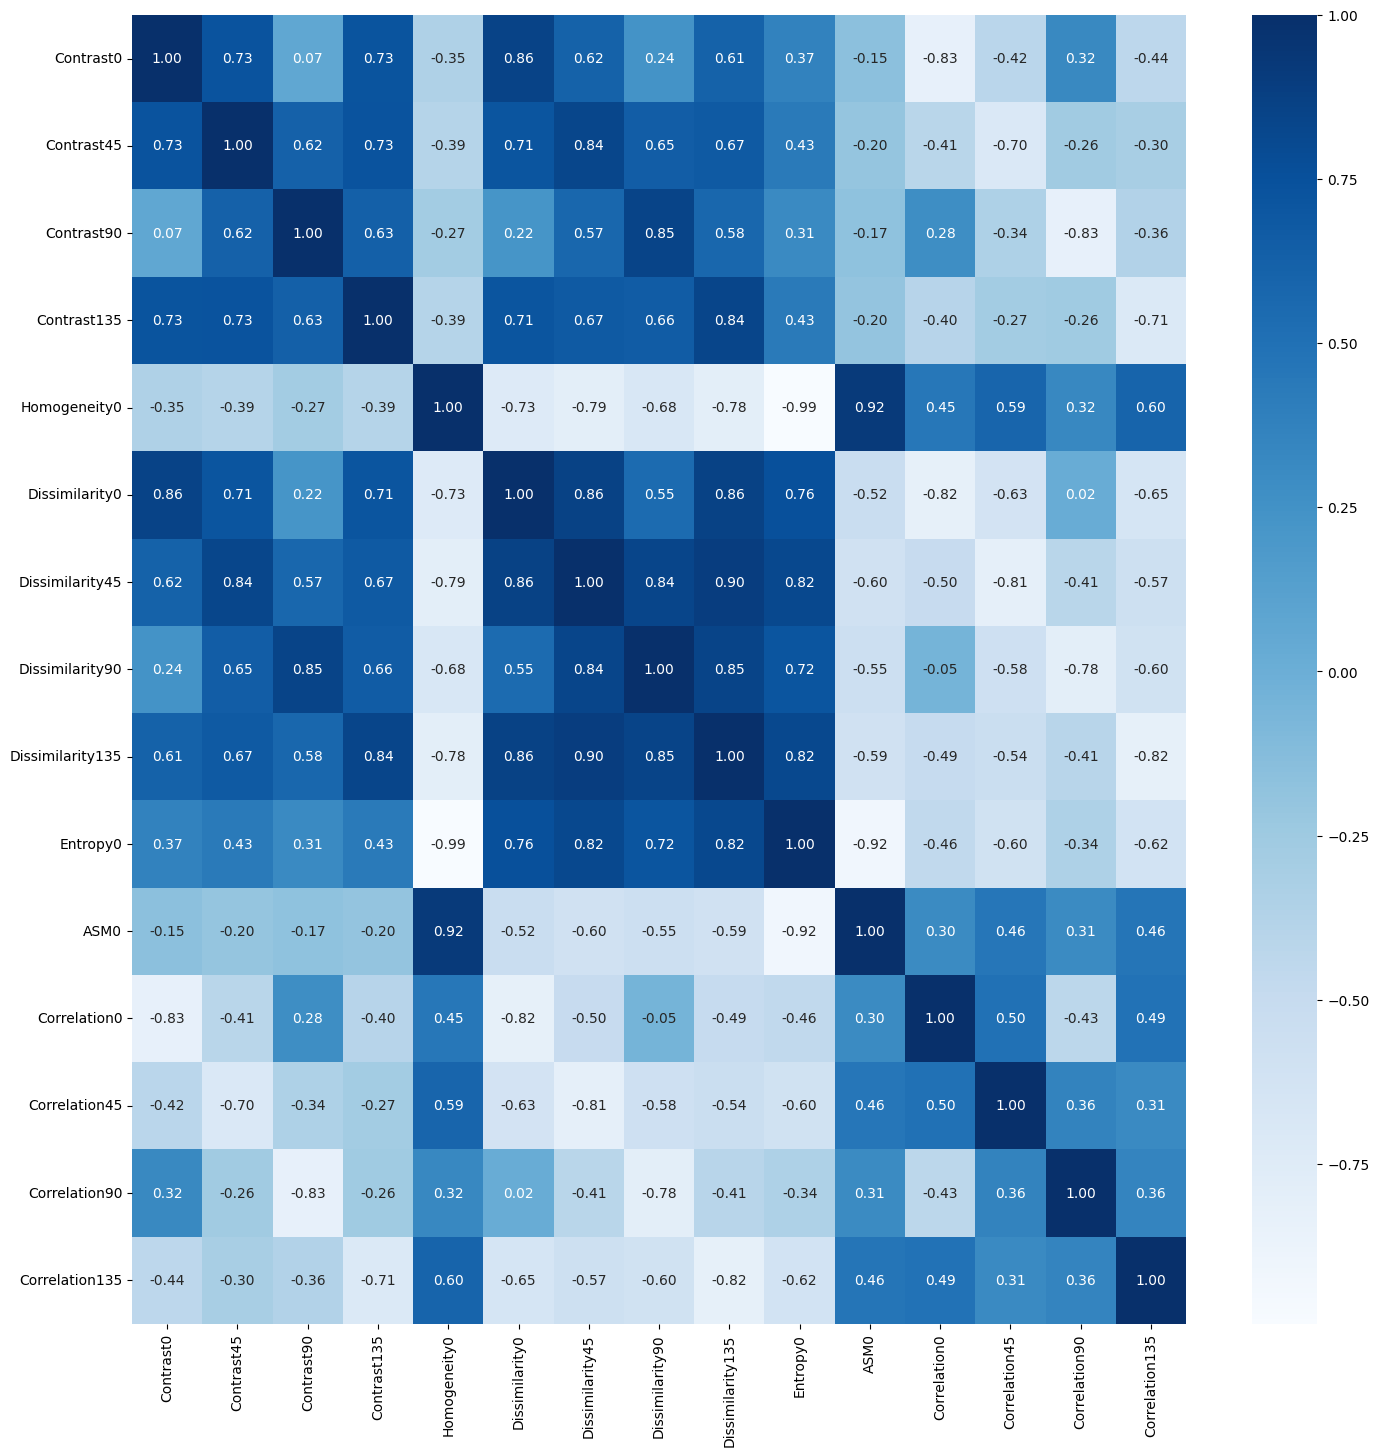

In [29]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# Splitting Data

In [37]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(940, 15)
(236, 15)


 <p align="justify">Pada bagian kode ini, dilakukan proses pembagian data menjadi data latih (training) dan data uji (testing) menggunakan fungsi train_test_split dari pustaka scikit-learn. Data fitur yang telah diseleksi dan disimpan dalam x_new digunakan sebagai input (variabel X), sedangkan label kelas pada variabel y digunakan sebagai target output. Parameter test_size=0.2 menunjukkan bahwa 20% dari total data akan digunakan sebagai data uji, sementara 80% sisanya akan digunakan untuk melatih model. Opsi random_state=42 ditetapkan agar proses pembagian data bersifat konsisten dan dapat direproduksi—artinya, jika kode dijalankan ulang, pembagian data akan tetap sama. Hasil pembagian disimpan dalam empat variabel: X_train dan y_train untuk data latih, serta X_test dan y_test untuk data uji. Terakhir, ukuran dari data latih dan data uji dicetak dengan print(X_train.shape) dan print(X_test.shape), yang menunjukkan jumlah sampel dan jumlah fitur pada masing-masing subset data. Informasi ini penting untuk memastikan bahwa pembagian data telah sesuai proporsi dan cukup untuk melatih serta menguji model pembelajaran mesin.</p>

# Feature Normalization

In [38]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

<p align="justify">Di bagian kode ini, dilakukan proses standarisasi data fitur agar setiap kolom memiliki nilai rata-rata nol dan standar deviasi satu. Caranya adalah dengan mengurangi setiap nilai fitur dengan rata-rata fitur tersebut yang dihitung dari data pelatihan (X_train.mean()), kemudian membaginya dengan standar deviasi fitur yang sama dari data pelatihan (X_train.std()). Langkah ini penting karena memastikan bahwa semua fitur berada pada skala yang sama, sehingga model pembelajaran mesin tidak berat sebelah terhadap fitur dengan nilai yang lebih besar atau lebih kecil. Selain itu, proses normalisasi ini juga diterapkan ke data uji (X_test), tetapi menggunakan nilai rata-rata dan standar deviasi yang berasal dari data pelatihan, bukan data uji. Hal ini dilakukan agar model diuji dengan data yang distandarisasi secara konsisten dengan data saat pelatihan, sehingga hasil evaluasi menjadi lebih valid dan reliabel.</p>

# Modeling Define Model

In [39]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

<p align="justify">Fungsi generateClassificationReport dibuat untuk memudahkan evaluasi performa model klasifikasi dengan menerima dua input utama, yaitu y_true (label asli atau sebenarnya) dan y_pred (label yang diprediksi oleh model). Fungsi ini kemudian mencetak tiga hal penting: laporan klasifikasi lengkap yang menampilkan metrik seperti presisi, recall, dan F1-score untuk setiap kelas, matriks kebingungan (confusion matrix) yang memperlihatkan detail kesalahan klasifikasi, serta akurasi keseluruhan model. Selanjutnya, didefinisikan tiga model klasifikasi yang umum digunakan: RandomForestClassifier dengan 5 pohon keputusan (n_estimators=5) dan pengacakan tetap (random_state=42) untuk memastikan hasil konsisten; SVC dengan kernel radial basis function (rbf), yang efektif untuk menangani data non-linear; serta KNeighborsClassifier dengan jumlah tetangga terdekat sebanyak 5 (n_neighbors=5). Ketiga model ini siap digunakan untuk dilatih dan diuji dalam pipeline klasifikasi, memberikan berbagai pendekatan yang bisa dibandingkan performanya dalam mengklasifikasikan data.</p>

# Train Random Forest Classifier

In [40]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

   FreshFish       1.00      1.00      1.00       522
InfectedFish       1.00      1.00      1.00       418

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

[[521   1]
 [  2 416]]
Accuracy: 0.9968085106382979

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.93      0.97      0.95       130
InfectedFish       0.96      0.92      0.94       106

    accuracy                           0.94       236
   macro avg       0.95      0.94      0.94       236
weighted avg       0.95      0.94      0.94       236

[[126   4]
 [  9  97]]
Accuracy: 0.9449152542372882


<p align="justify">evaluasi pada training set, model digunakan untuk memprediksi label dari X_train dengan fungsi .predict(), kemudian hasil prediksi tersebut (y_pred) dibandingkan dengan label sebenarnya (y_train) menggunakan fungsi generateClassificationReport(). Fungsi ini akan mencetak metrik-metrik evaluasi penting seperti presisi, recall, F1-score, akurasi, dan confusion matrix.</p>

<p align="justify">Kemudian, proses yang sama dilakukan untuk testing set. Model memprediksi X_test, lalu hasil prediksinya dibandingkan dengan y_test. Evaluasi terhadap data testing ini penting untuk mengetahui seberapa baik model mampu menggeneralisasi terhadap data baru yang belum pernah dilihat. Dengan membandingkan performa di training dan testing set, pengguna dapat mengidentifikasi apakah model mengalami overfitting (jika akurasi training jauh lebih tinggi dari testing) atau underfitting (jika kedua akurasi sama-sama rendah).</p>

# Train SVM Classifier

In [41]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.91      0.96      0.93       522
InfectedFish       0.95      0.88      0.91       418

    accuracy                           0.93       940
   macro avg       0.93      0.92      0.92       940
weighted avg       0.93      0.93      0.93       940

[[503  19]
 [ 51 367]]
Accuracy: 0.925531914893617

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.93      0.97      0.95       130
InfectedFish       0.96      0.91      0.93       106

    accuracy                           0.94       236
   macro avg       0.94      0.94      0.94       236
weighted avg       0.94      0.94      0.94       236

[[126   4]
 [ 10  96]]
Accuracy: 0.940677966101695


<p align="justify">Pada bagian kode ini, dilakukan pelatihan dan evaluasi model klasifikasi menggunakan algoritma Support Vector Machine (SVM). Model svm, yang sebelumnya telah didefinisikan dengan kernel RBF (Radial Basis Function), dilatih menggunakan data pelatihan X_train dan label-nya y_train melalui metode .fit(). Setelah proses pelatihan selesai, model diuji terlebih dahulu pada data pelatihan untuk melihat sejauh mana model berhasil mempelajari pola dari data yang diberikan.</p>

<p align="justify">Prediksi pada data pelatihan dilakukan dengan svm.predict(X_train), lalu hasil prediksi dibandingkan dengan label sebenarnya (y_train) menggunakan fungsi generateClassificationReport, yang mencetak metrik evaluasi seperti presisi, recall, F1-score, confusion matrix, dan akurasi.</p>

<p align="justify">Setelah itu, model diuji pada data testing X_test untuk mengetahui kemampuan generalisasi model terhadap data baru yang belum pernah dilihat sebelumnya. Prediksi hasil testing (y_pred) dibandingkan dengan label asli (y_test) menggunakan fungsi evaluasi yang sama. Evaluasi ini penting untuk mengetahui apakah model SVM yang telah dilatih hanya cocok dengan data pelatihan (overfitting) atau juga mampu bekerja dengan baik pada data yang lebih umum (generalizable). Dengan membandingkan performa di dua tahap ini, kita bisa menentukan apakah model SVM layak digunakan atau perlu dilakukan tuning lebih lanjut.</p>

# Train KNN Classifier

In [42]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.97      0.98      0.98       522
InfectedFish       0.98      0.97      0.97       418

    accuracy                           0.97       940
   macro avg       0.97      0.97      0.97       940
weighted avg       0.97      0.97      0.97       940

[[512  10]
 [ 14 404]]
Accuracy: 0.9744680851063829

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.97      0.96      0.97       130
InfectedFish       0.95      0.96      0.96       106

    accuracy                           0.96       236
   macro avg       0.96      0.96      0.96       236
weighted avg       0.96      0.96      0.96       236

[[125   5]
 [  4 102]]
Accuracy: 0.961864406779661


<p align="justify">Pada bagian kode ini, digunakan algoritma K-Nearest Neighbors (KNN) untuk melakukan pelatihan dan evaluasi model klasifikasi. Model knn, yang sebelumnya didefinisikan dengan n_neighbors=5, dilatih menggunakan data X_train dan y_train melalui fungsi .fit(). KNN bekerja dengan cara mengklasifikasikan data baru berdasarkan mayoritas label dari sejumlah tetangga terdekat (dalam hal ini 5 tetangga) dalam ruang fitur.</p>

<p align="justify">Setelah pelatihan, dilakukan evaluasi terhadap performa model pada data pelatihan. Model memprediksi label dari X_train, dan hasil prediksi dibandingkan dengan label aslinya (y_train) menggunakan fungsi generateClassificationReport. Fungsi ini akan mencetak metrik penting seperti presisi, recall, F1-score, confusion matrix, dan akurasi, untuk menilai seberapa baik model mengenali pola dalam data latih.</p>

<p align="justify">Langkah yang sama dilakukan untuk menguji model pada data testing (X_test) yang belum pernah dilihat oleh model. Hasil prediksi dibandingkan dengan label asli y_test, dan metrik evaluasinya juga dicetak. Evaluasi ini sangat penting untuk mengetahui seberapa baik model KNN mampu melakukan generalisasi terhadap data baru. Jika akurasi pada data training sangat tinggi tetapi rendah pada data testing, maka bisa jadi model terlalu overfit. Namun, jika keduanya seimbang dan tinggi, maka model KNN dapat dianggap baik dalam menangani data klasifikasi yang diberikan.</p>

# Evaluation With Confusion Matrix

<p align="justify">Pada bagian kode ini, dibuat sebuah fungsi bernama plot_confusion_matrix yang digunakan untuk menampilkan Confusion Matrix secara visual. Fungsi ini menerima tiga parameter: y_true (label sebenarnya), y_pred (label hasil prediksi model), dan title (judul grafik). Di dalam fungsi, pertama-tama dihitung confusion matrix menggunakan confusion_matrix dari sklearn, lalu ditampilkan secara visual melalui ConfusionMatrixDisplay. Warna latar belakang matriks diatur menggunakan colormap biru (plt.cm.Blues) agar lebih mudah dibaca, dan judul grafik ditampilkan sesuai parameter yang diberikan. Fungsi plt.show() digunakan untuk menampilkan hasil plot ke layar.</p>

<p align="justify">Selanjutnya, fungsi ini dipanggil tiga kali, masing-masing untuk menampilkan confusion matrix dari hasil prediksi tiga model berbeda: Random Forest, SVM, dan KNN, semuanya terhadap data testing (y_test). Visualisasi confusion matrix ini sangat berguna untuk memahami secara lebih jelas pola kesalahan model dalam mengklasifikasikan data—misalnya, seberapa banyak sampel dari satu kelas yang diklasifikasikan secara keliru menjadi kelas lain. Ini membantu analisis performa model secara lebih mendalam dibandingkan hanya melihat akurasi.</p>

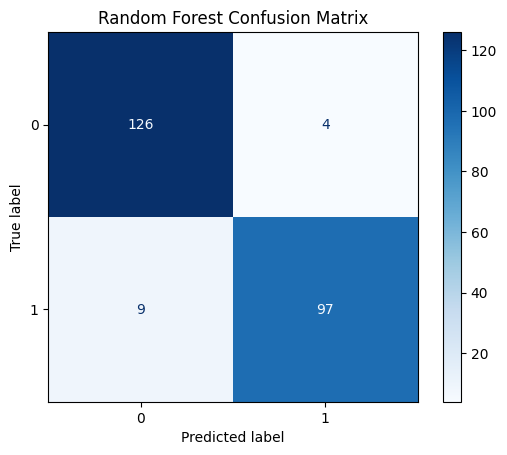

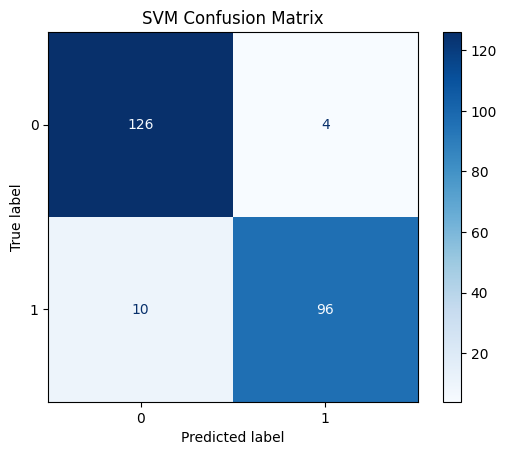

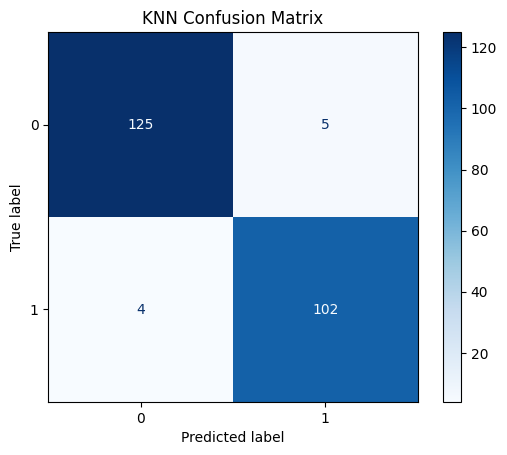

In [43]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

# Analisis Hasil Matrix Confusion

Berdasarkan visualisasi, KNN menunjukkan kinerja terbaik dalam percobaan ini, dengan hanya mencatat 5 False Positive dan 4 False Negative, sehingga total kesalahan klasifikasi hanya 9 dari seluruh data. Ini mengindikasikan bahwa KNN mampu memetakan data dengan cukup baik dan seimbang antara kedua kelas.

Random Forest juga menunjukkan kinerja yang sangat baik, dengan hanya 4 False Positive dan 9 False Negative, menjadikan total kesalahan sebanyak 13. Hasil ini mencerminkan kemampuan model dalam mengklasifikasikan data secara cukup akurat, meskipun terdapat sedikit penurunan dalam mengenali kelas positif dibandingkan KNN. Sedangkan SVM memiliki performa yang sedikit lebih rendah dibanding dua model lainnya, dengan 4 False Positive dan 10 False Negative, atau total 14 kesalahan klasifikasi. Hal ini menunjukkan bahwa SVM sedikit lebih sering gagal mengenali kelas positif dibandingkan KNN dan Random Forest.

Secara keseluruhan, semua model menunjukkan performa yang cukup baik, tetapi dari hasil yang ditampilkan, KNN memiliki keunggulan dari sisi akurasi total kesalahan terkecil, diikuti oleh Random Forest, dan terakhir SVM.